#First Version: Andre Sznajder (UERJ/CMS) 
#Current Version: Fernando Augusto A. Neto (UERJ/CMS)

It's a tribute to Isaac Asimov, the great master of Science fiction and my favorites tales: \\
The Last Question \\
All the Troubles of the World

#Mount Google Drive

In [0]:
!fusermount -u drive
!pip install uproot
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
root_dir = "/content/gdrive/My Drive/"
data_dir = "/content/gdrive/My Drive/Colab Notebooks/Data/"
!ls {data_dir}

fusermount: failed to unmount /content/drive: No such file or directory
Mounted at /content/gdrive
ls: cannot access '/content/gdrive/My': No such file or directory
ls: cannot access 'Drive/Colab': No such file or directory
ls: cannot access 'Notebooks/Data/': No such file or directory


#Load data using PANDAS data frames
Now we load two different NumPy arrays. One corresponding to the VBF H->ZZ->4l signal and the other one corresponds to the full set of backgrounds .

In [0]:
import uproot
import numpy as np
import pandas as pd
import h5py

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

filename = {}
upfile = {}
data = {}
df = {}

#Here I insert the samples generated in the create_HZZ-histos.py macro and saved in data_dir
#data_dir = '/content/gdrive/My Drive/Colab Notebooks/Data/'
filename['sig'] = data_dir+'three_my_signal.csv'
filename['bkg'] = data_dir+'three_my_background.csv'

# Variables from Roottree to be copyed to PANDA dataframe

VARS = [ 'proc', 'f_run', 'f_event', 'f_weight', \
        'f_massjj', 'f_deltajj', 'f_mass4l', 'f_Z1mass' , 'f_Z2mass', \
        'f_lept1_pdgid', 'f_lept2_pdgid', 'f_lept3_pdgid', 'f_lept4_pdgid', \
        'f_lept1_pt','f_lept1_eta','f_lept1_phi', \
        'f_lept2_pt','f_lept2_eta','f_lept2_phi', \
        'f_lept3_pt','f_lept3_eta','f_lept3_phi', \
        'f_lept4_pt','f_lept4_eta','f_lept4_phi', \
        'f_jet1_pt','f_jet1_eta','f_jet1_phi', \
        'f_jet2_pt','f_jet2_eta','f_jet2_phi', \
        'f_jet3_pt','f_jet3_eta','f_jet3_phi' ]
        
# Read CSV signal and background files into pandas Dataframe
df['sig']  = pd.read_csv(filename['sig'])
df['bkg']  = pd.read_csv(filename['bkg'])
df['sig'].columns = VARS
df['bkg'].columns = VARS

# Crop the background sample to have the same number of events as the signal sample
#df['bkg']=df['bkg'][:len(df['sig'])]

print(len(df['sig']))
print(len(df['bkg']))

# Remove undefined variable entries VARS[i] <= -999
#for i in range(len(VARS)): 
#  df['sig'] = df['sig'][(df['sig'][VARS[i]] > -999)]
#  df['bkg'] = df['bkg'][(df['bkg'][VARS[i]] > -999)]

26591
44357


Prepare data for NN input

In [0]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Add the variable isSignal to the dataframe containing the signal and background events
df['sig']['isSignal']=  np.ones(len(df['sig'])) 
df['bkg']['isSignal'] = np.zeros(len(df['bkg'])) 

print("Number SIG events=", len(df['sig']))
print("Number BKG events=", len(df['bkg']))
print('signal=',df['sig'])
print('signal=',df['bkg'])


# Renormalizes the events weights to give unit sum in the signal and background dataframes
# This is necessary for the NN to learn signal and background in the same proportion , 
#   independently of number of events and absolute weights of events in each sample !
df['sig']['f_weight']=df['sig']['f_weight']/df['sig']['f_weight'].sum(axis=0)
df['bkg']['f_weight']=df['bkg']['f_weight']/df['bkg']['f_weight'].sum(axis=0)


# Concatenate the signal and background in a single  data frames 
df_all = pd.concat([df['sig'],df['bkg']])

# Random shuffles the dataset to mix signal and background events before splitting between train and test samples
df_all = shuffle(df_all)

# Filter dataframe leaving just NN input variables  
#NN_VARS = [ 'f_massjj', 'f_deltajj', 'f_Z2mass', \
NN_VARS = [ 'f_lept1_pdgid', 'f_lept2_pdgid', 'f_lept3_pdgid', 'f_lept4_pdgid', \
            'f_lept1_pt','f_lept1_eta','f_lept1_phi', \
            'f_lept2_pt','f_lept2_eta','f_lept2_phi', \
            'f_lept3_pt','f_lept3_eta','f_lept3_phi', \
            'f_lept4_pt','f_lept4_eta','f_lept4_phi', \
            'f_jet1_pt','f_jet1_eta','f_jet1_phi', \
            'f_jet2_pt','f_jet2_eta','f_jet2_phi']
         
df_input  = df_all.filter(NN_VARS)
df_target = df_all.filter(['isSignal'])
df_weights = df_all.filter(['f_weight'])

# Transform dataframes to numpy arrays of float32 (. X->NN input , Y->NN target output , W-> event weights)
NINPUT=len(NN_VARS)
print("Number NN input variables=",NINPUT)
print("NN input variables=",NN_VARS)
X  = np.asarray( df_input.values ).astype(np.float32)
Y  = np.asarray( df_target.values ).astype(np.float32)
W  = np.asarray( df_weights.values ).astype(np.float32)
print('w=', len(W))
print('X=', len(X))
# Split the sample into train and test  
X_train_val, X_test, Y_train_val, Y_test , W_train_val , W_test = train_test_split(X, Y, W , test_size=0.2, shuffle=True)


#print(len(W_train_val))
#for i in range(20): print("X_train_val=",X_train_val[i])
#for i in range(20): print("Y_train_val=",Y_train_val[i])
#for i in range(20): print("w_train_val=",W_train_val[i])
#weights=X_train_val[:NINPUT]
#print('pesos=',weights)


print("W_test=",W_test.max(axis=0))
print("w_test=",W_test.min(axis=0))
print("Signal Max Weight=",df['sig']['f_weight'].max(axis=0))
print("Signal Min Weight=",df['sig']['f_weight'].min(axis=0))
print("Background Max Weight=",df['bkg']['f_weight'].max(axis=0))
print("Background Min Weight=",df['bkg']['f_weight'].min(axis=0))

Number SIG events= 26591
Number BKG events= 44357
signal=          proc  f_run  f_event  ...  f_jet3_eta  f_jet3_phi  isSignal
0      VBFHZZ      1   385425  ... -999.000000 -999.000000       1.0
1      VBFHZZ      1   385453  ... -999.000000 -999.000000       1.0
2      VBFHZZ      1   385579  ... -999.000000 -999.000000       1.0
3      VBFHZZ      1   393263  ... -999.000000 -999.000000       1.0
4      VBFHZZ      1   393349  ...   -2.661322    0.794578       1.0
...       ...    ...      ...  ...         ...         ...       ...
26586  VBFHZZ      1   498441  ... -999.000000 -999.000000       1.0
26587  VBFHZZ      1   498496  ... -999.000000 -999.000000       1.0
26588  VBFHZZ      1   498645  ... -999.000000 -999.000000       1.0
26589  VBFHZZ      1   498655  ...   -1.434555    2.633955       1.0
26590  VBFHZZ      1   498778  ... -999.000000 -999.000000       1.0

[26591 rows x 35 columns]
signal=         proc  f_run  f_event  ...  f_jet3_eta  f_jet3_phi  isSignal
0      ggHZ

#Define the model using KERAS functional API

We'll start with a dense (fully-connected) NN layer. Our model will have a single fully-connected hidden layer with the same number of neurons as input variables. The output layer contains a single neuron using a sigmoid activation in order to a number between 0 and 1 to make binary classification
We are using the binary_crossentropy loss function during training, a standard loss function for binary classification problems. We will optimize the model with the Adam algorithm for stochastic gradient descent and we will collect accuracy metrics while the model is trained.

In [0]:
# baseline keras model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Input, Activation, Dense, Dropout
from tensorflow.keras import utils
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

model = Sequential()
#Input and first hidden layer with dropout
model.add(Dense(units=NINPUT*3, activation='relu', kernel_initializer='normal', input_dim=NINPUT))
model.add(Dropout(rate=0.2))

#Second hidden layer with dropou
model.add(Dense(units=NINPUT*0.5, activation='relu', kernel_initializer='normal'))
model.add(Dropout(rate=0.2))

#third layer with dropout
model.add(Dense(units=NINPUT*0.25, activation='relu', kernel_initializer='normal'))
model.add(Dropout(rate=0.2))

#Output layer
model.add(Dense(units=1, activation='sigmoid'))
#Compile method
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'], weighted_metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 66)                1518      
_________________________________________________________________
dropout (Dropout)            (None, 66)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 11)                737       
_________________________________________________________________
dropout_1 (Dropout)          (None, 11)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 60        
_________________________________________________________________
dropout_2 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6

#Training


In [0]:
#callbacks-->  criteria to earlyStopping and best configuration 
#es = EarlyStopping(monitor='loss', min_delta=1e-10, patience=10, verbose=1)
#rlr = ReduceLROnPlateau(monitor= 'loss', factor= 0.2, patience = 5, verbose=1)
#mcp = ModelCheckpoint(filepath='pesos.h5', monitor='loss', save_best_only=True, verbose=1)

# Number of training epochs
nepochs=100
# Batch size
batch=500
# Train classifier
history = model.fit(X_train_val, 
                    Y_train_val,
                    epochs=nepochs, 
                    sample_weight=W_train_val,
                    batch_size=batch, 
                    verbose=1, # switch to 1 for more verbosity 
                    validation_split=0.3)#, callbacks=[es, rlr, mcp])
#the callbacks didn't bring a good result

Epoch 1/100
80/80 [==============================] - 2s 26ms/step - loss: 1.9706e-05 - accuracy: 0.5846 - weighted_accuracy: 0.5078 - val_loss: 1.9333e-05 - val_accuracy: 0.6224 - val_weighted_accuracy: 0.4886
Epoch 2/100
80/80 [==============================] - 2s 23ms/step - loss: 1.9648e-05 - accuracy: 0.5908 - weighted_accuracy: 0.5151 - val_loss: 1.9249e-05 - val_accuracy: 0.5075 - val_weighted_accuracy: 0.5540
Epoch 3/100
80/80 [==============================] - 2s 23ms/step - loss: 1.9631e-05 - accuracy: 0.5489 - weighted_accuracy: 0.5223 - val_loss: 1.9225e-05 - val_accuracy: 0.5107 - val_weighted_accuracy: 0.5666
Epoch 4/100
80/80 [==============================] - 2s 23ms/step - loss: 1.9589e-05 - accuracy: 0.5450 - weighted_accuracy: 0.5332 - val_loss: 1.9345e-05 - val_accuracy: 0.6097 - val_weighted_accuracy: 0.4952
Epoch 5/100
80/80 [==============================] - 2s 23ms/step - loss: 1.9562e-05 - accuracy: 0.5686 - weighted_accuracy: 0.5411 - val_loss: 1.9170e-05 - val

#Plot performance(ROC, accuracy, loss, DNN output)

Here, we plot the history of the training and the performance in a ROC curve

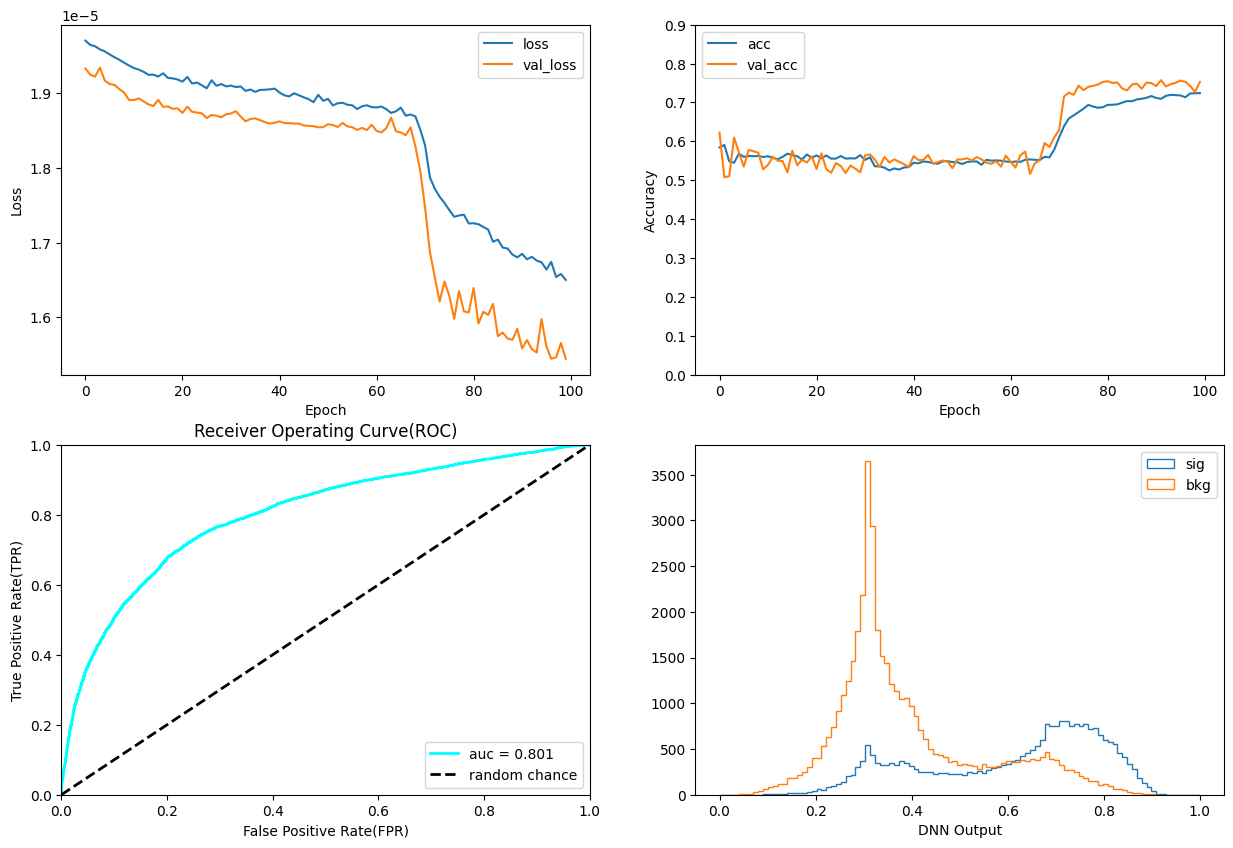

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')
plt.figure(figsize=(15,10))

# plot loss vs epoch
ax = plt.subplot(2, 2, 1)
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val_loss')
#ax.set_ylim([0, 1.0])
ax.legend(loc="upper right")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# plot accuracy vs epoch
ax = plt.subplot(2, 2, 2)
ax.plot(history.history['accuracy'], label='acc')
ax.plot(history.history['val_accuracy'], label='val_acc')
ax.set_ylim([0, 0.9])
ax.legend(loc="upper left")
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')

# Plot ROC
Y_predict = model.predict(X_test[:,0:NINPUT])#ficar de olho aqui
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
roc_auc = auc(fpr, tpr)
ax = plt.subplot(2, 2, 3)
ax.plot(fpr, tpr, lw=2, color='cyan', label='auc = %.3f' % (roc_auc))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
ax.set_xlim([0, 1.0])
ax.set_ylim([0, 1.0])
ax.set_xlabel('False Positive Rate(FPR)')
ax.set_ylabel('True Positive Rate(TPR)')
ax.set_title('Receiver Operating Curve(ROC)')
ax.legend(loc="lower right")

# Plot DNN output 
df_sig  = df['sig'].filter(NN_VARS)
df_bkg  = df['bkg'].filter(NN_VARS)

X_sig  = np.asarray( df_sig.values ).astype(np.float32)
X_bkg  = np.asarray( df_bkg.values ).astype(np.float32)

Y_sig = model.predict(X_sig)
Y_bkg = model.predict(X_bkg)

ax = plt.subplot(2, 2, 4)
X = np.linspace(0.0, 1.0, 100)
hist_sig = ax.hist(Y_sig, bins=X, label='sig',histtype='step')
hist_bkg = ax.hist(Y_bkg, bins=X, label='bkg',histtype='step',)

#ax.hist(Y_train_val, bins=X, label='bkg',histtype='step')

ax.set_xlabel('DNN Output')
ax.legend(prop={'size': 10})
plt.show()

#Deltajj and Massjj

0.7069309164754992
0.5536399564694426


(-5.0, 5.0)

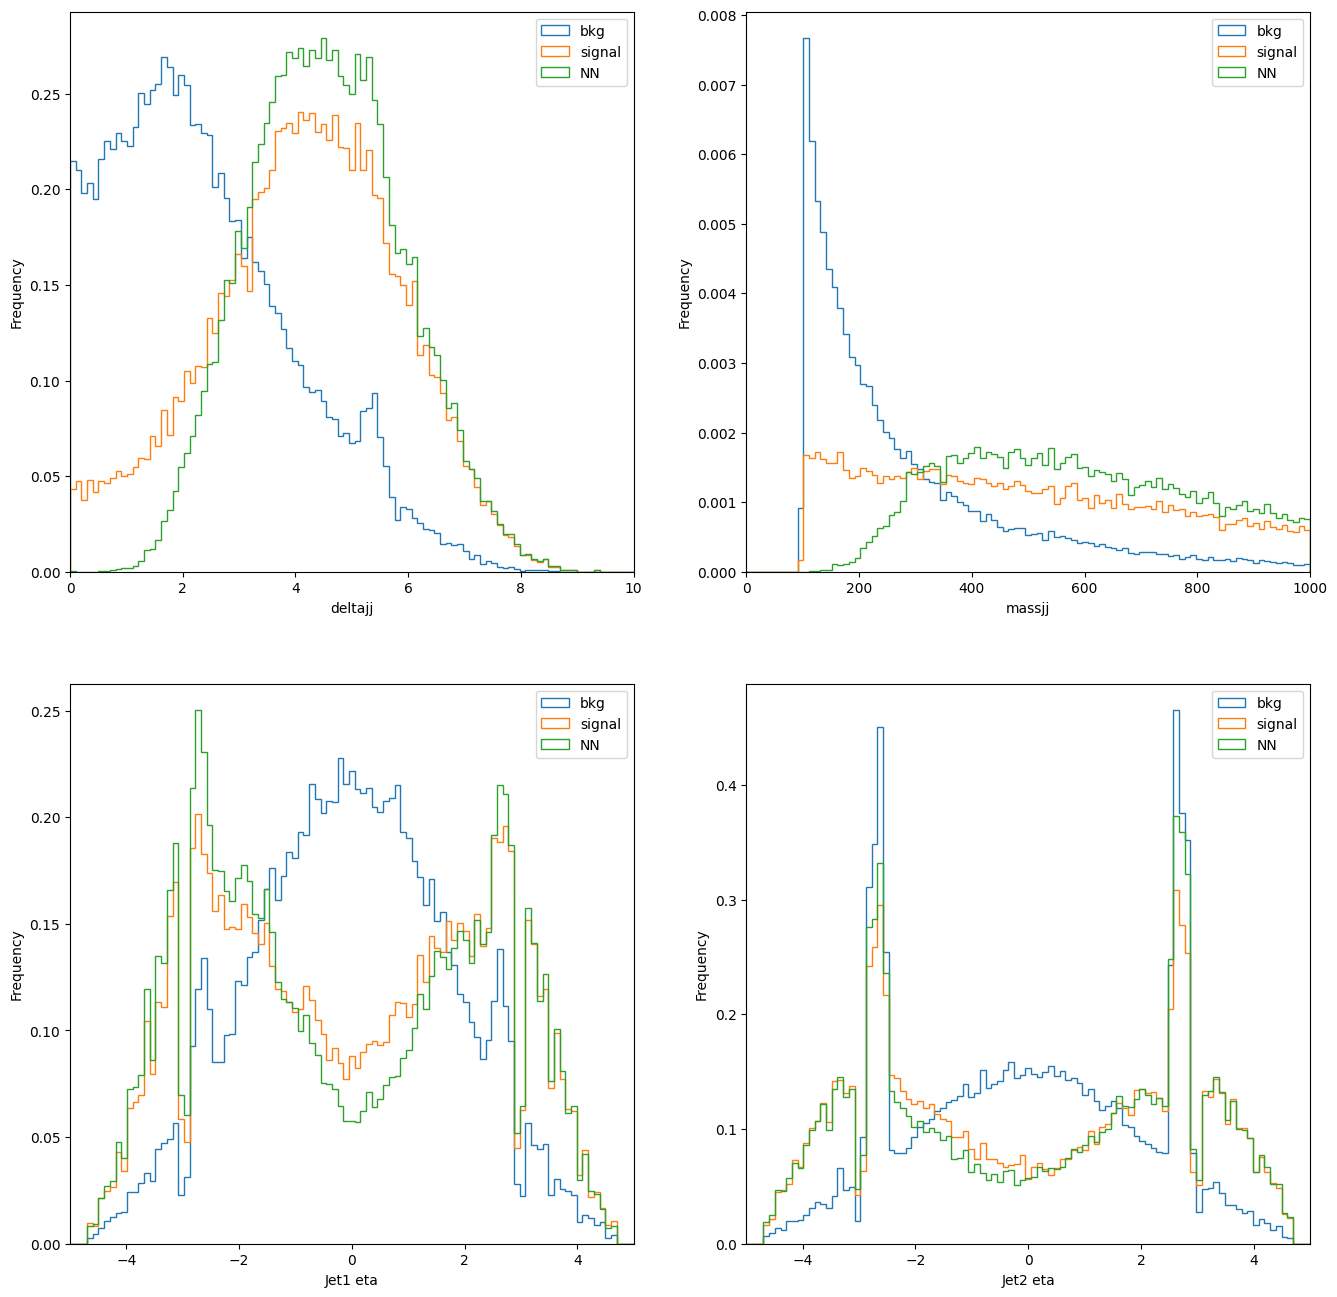

In [0]:
import matplotlib.pyplot as plt

# Define the data frame of high level variables and NN output
data = df_all.filter(NN_VARS)
X_all   = np.asarray( data.values ).astype(np.float32)
Y_all = model.predict(X_all)

# Add the NN prediction array ( Y_all ) column to the complete dataframe
df_all['NNoutput'] = Y_all

# Selects events with NNoutput > cut
cut = 0.5 
df_sel   = df_all[(df_all['NNoutput'] >= cut)]
df_TP    = df_all[(df_all['NNoutput'] >= cut) & (df_all['isSignal'] == 1)]
df_unsel = df_all[(df_all['NNoutput'] < cut)]
df_TN    = df_all[(df_all['NNoutput'] < cut) & (df_all['isSignal'] == 0)]

TP = len(df_TP)
FP = len(df_sel) - TP
TN = len(df_TN)
FN = len(df_unsel) - TN

truepositiverate = float(TP)/(TP+FN)
fakepositiverate = float(FP)/(FP+FN)
print(truepositiverate)
print(fakepositiverate)
    
# Plot high level variables for signal, background and NN selected events 
plt.style.use('default') # It's ugly otherwise
plt.figure(figsize=(16, 16),dpi=100)

plt.subplot(2, 2, 1)
plt.xlabel('deltajj')
X = np.linspace(0.0,10.,100)
df_all['f_deltajj'][(df_all['isSignal'] == 0)].plot.hist(bins=X, label='bkg',histtype='step', density=1)
df_all['f_deltajj'][(df_all['isSignal'] == 1)].plot.hist(bins=X, label='signal',histtype='step', density=1)
df_sel['f_deltajj'].plot.hist(bins=X, label='NN',histtype='step', density=1)
plt.legend(loc='upper right')
plt.xlim(0,10)

# Plot  dijets mass for signal, background and NN selected events 
plt.subplot(2, 2, 2)
plt.xlabel('massjj')
X = np.linspace(0.0,1000.,100)
df_all['f_massjj'][(df_all['isSignal'] == 0)].plot.hist(bins=X, label='bkg',histtype='step', density=1)
df_all['f_massjj'][(df_all['isSignal'] == 1)].plot.hist(bins=X, label='signal',histtype='step', density=1)
df_sel['f_massjj'].plot.hist(bins=X, label='NN',histtype='step', density=1)
plt.legend(loc='upper right')
plt.xlim(0,1000)


# Plot Jet1 eta for signal, background and NN selected events 
plt.subplot(2, 2, 3)
plt.xlabel('Jet1 eta')
X = np.linspace(-5.,5.,100)
df_all['f_jet1_eta'][(df_all['isSignal'] == 0)].plot.hist(bins=X, label='bkg',histtype='step', density=1)
df_all['f_jet1_eta'][(df_all['isSignal'] == 1)].plot.hist(bins=X, label='signal',histtype='step', density=1)
df_sel['f_jet1_eta'].plot.hist(bins=X, label='NN',histtype='step', density=1)
plt.legend(loc='upper right')
plt.xlim(-5,5)

# Plot Jet2 eta for signal, background and NN selected events 
plt.subplot(2, 2, 4)
plt.xlabel('Jet2 eta')
X = np.linspace(-5.,5.,100)
df_all['f_jet2_eta'][(df_all['isSignal'] == 0)].plot.hist(bins=X, label='bkg',histtype='step', density=1)
df_all['f_jet2_eta'][(df_all['isSignal'] == 1)].plot.hist(bins=X, label='signal',histtype='step', density=1)
df_sel['f_jet2_eta'].plot.hist(bins=X, label='NN',histtype='step', density=1)
plt.legend(loc='upper right')
plt.xlim(-5,5)

# Pt to leptons 1, 2, 3 and 4

(0.0, 100.0)

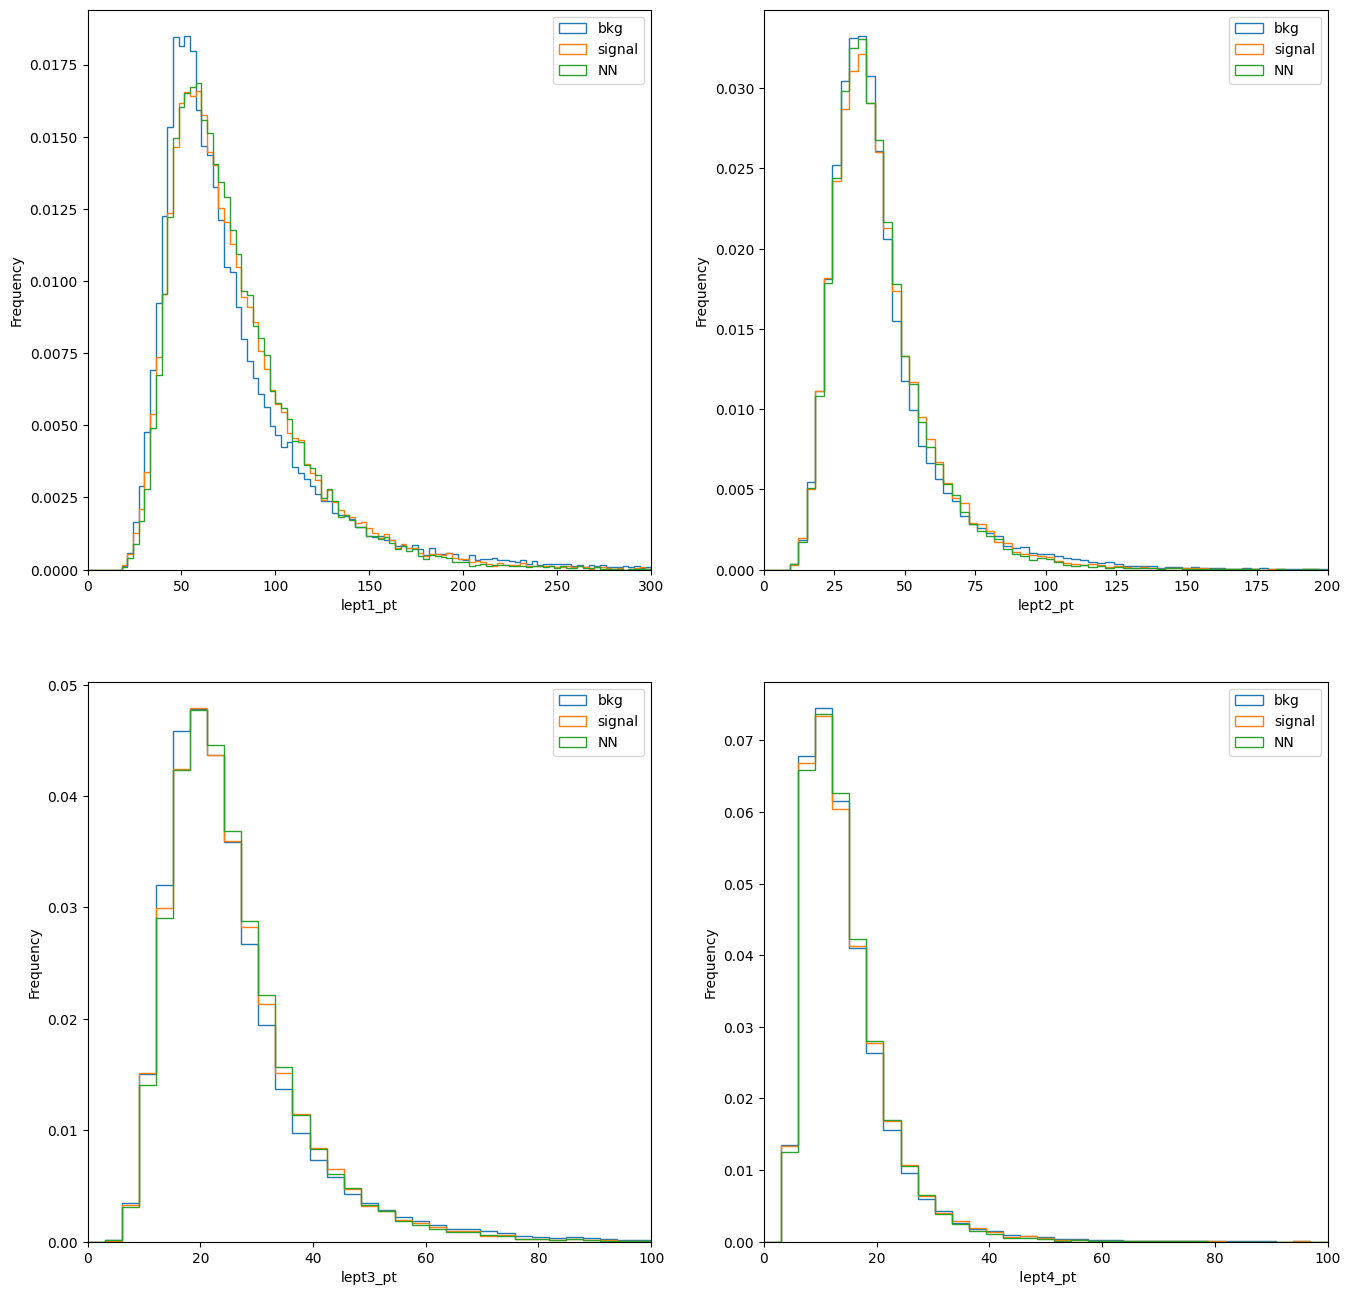

In [0]:
# Plot high level variables for signal, background and NN selected events 
plt.style.use('default') # It's ugly otherwise
plt.figure(figsize=(16, 16),dpi=100)

plt.subplot(2, 2, 1)
plt.xlabel('lept1_pt')
X = np.linspace(0.0,300.,100)
df_all['f_lept1_pt'][(df_all['isSignal'] == 0)].plot.hist(bins=X, label='bkg',histtype='step', density=1)
df_all['f_lept1_pt'][(df_all['isSignal'] == 1)].plot.hist(bins=X, label='signal',histtype='step', density=1)
df_sel['f_lept1_pt'].plot.hist(bins=X, label='NN',histtype='step', density=1)
plt.legend(loc='upper right')
plt.xlim(0,300)

# Plot  dijets mass for signal, background and NN selected events 
plt.subplot(2, 2, 2)
plt.xlabel('lept2_pt')
X = np.linspace(0.0,300.,100)
df_all['f_lept2_pt'][(df_all['isSignal'] == 0)].plot.hist(bins=X, label='bkg',histtype='step', density=1)
df_all['f_lept2_pt'][(df_all['isSignal'] == 1)].plot.hist(bins=X, label='signal',histtype='step', density=1)
df_sel['f_lept2_pt'].plot.hist(bins=X, label='NN',histtype='step', density=1)
plt.legend(loc='upper right')
plt.xlim(0,200)


# Plot Jet1 eta for signal, background and NN selected events 
plt.subplot(2, 2, 3)
plt.xlabel('lept3_pt')
X = np.linspace(0.,300.,100)
df_all['f_lept3_pt'][(df_all['isSignal'] == 0)].plot.hist(bins=X, label='bkg',histtype='step', density=1)
df_all['f_lept3_pt'][(df_all['isSignal'] == 1)].plot.hist(bins=X, label='signal',histtype='step', density=1)
df_sel['f_lept3_pt'].plot.hist(bins=X, label='NN',histtype='step', density=1)
plt.legend(loc='upper right')
plt.xlim(0,100)

# Plot Jet2 eta for signal, background and NN selected events 
plt.subplot(2, 2, 4)
plt.xlabel(' lept4_pt')
X = np.linspace(0.,300.,100)
df_all['f_lept4_pt'][(df_all['isSignal'] == 0)].plot.hist(bins=X, label='bkg',histtype='step', density=1)
df_all['f_lept4_pt'][(df_all['isSignal'] == 1)].plot.hist(bins=X, label='signal',histtype='step', density=1)
df_sel['f_lept4_pt'].plot.hist(bins=X, label='NN',histtype='step', density=1)
plt.legend(loc='upper right')
plt.xlim(0,100)

#Eta to leptons 1, 2, 3 and 4

(-2.5, 2.5)

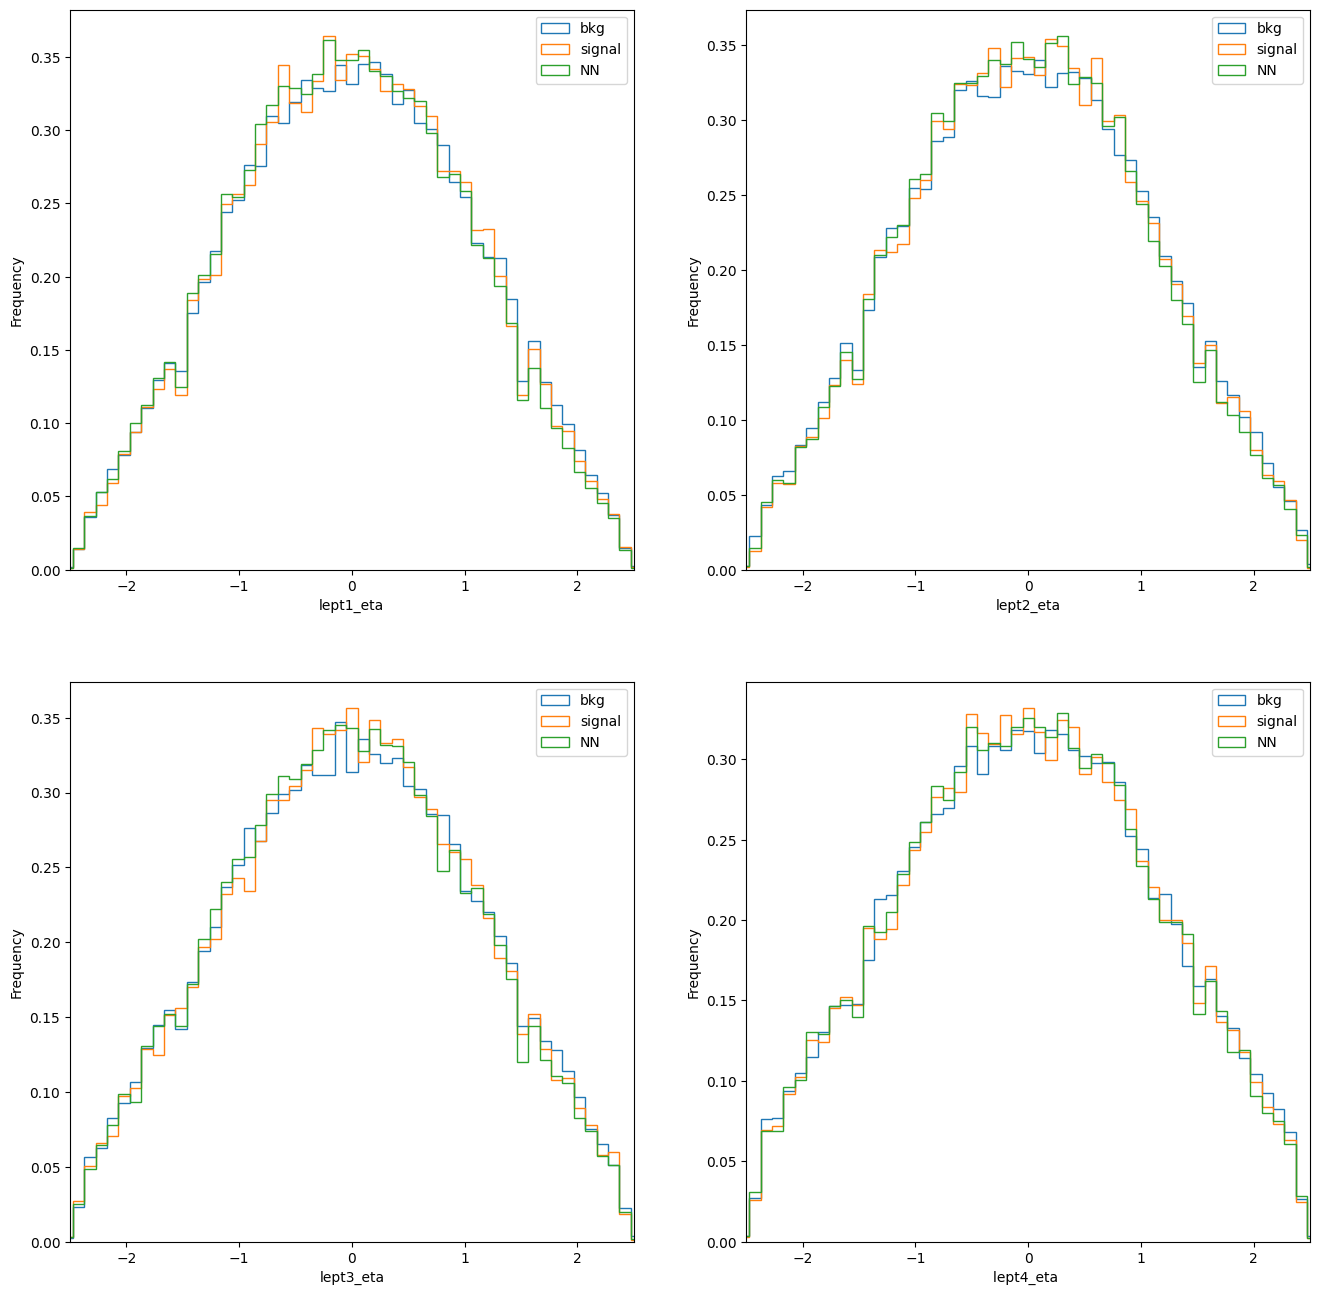

In [0]:
# Plot high level variables for signal, background and NN selected events 
plt.style.use('default') # It's ugly otherwise
plt.figure(figsize=(16, 16),dpi=100)

plt.subplot(2, 2, 1)
plt.xlabel('lept1_eta')
X = np.linspace(-5.,5.,100)
df_all['f_lept1_eta'][(df_all['isSignal'] == 0)].plot.hist(bins=X, label='bkg',histtype='step', density=1)
df_all['f_lept1_eta'][(df_all['isSignal'] == 1)].plot.hist(bins=X, label='signal',histtype='step', density=1)
df_sel['f_lept1_eta'].plot.hist(bins=X, label='NN',histtype='step', density=1)
plt.legend(loc='upper right')
plt.xlim(-2.5,2.5)

# Plot  dijets mass for signal, background and NN selected events 
plt.subplot(2, 2, 2)
plt.xlabel('lept2_eta')
X = np.linspace(-5.,5.,100)
df_all['f_lept2_eta'][(df_all['isSignal'] == 0)].plot.hist(bins=X, label='bkg',histtype='step', density=1)
df_all['f_lept2_eta'][(df_all['isSignal'] == 1)].plot.hist(bins=X, label='signal',histtype='step', density=1)
df_sel['f_lept2_eta'].plot.hist(bins=X, label='NN',histtype='step', density=1)
plt.legend(loc='upper right')
plt.xlim(-2.5,2.5)


# Plot Jet1 eta for signal, background and NN selected events 
plt.subplot(2, 2, 3)
plt.xlabel('lept3_eta')
X = np.linspace(-5.,5.,100)
df_all['f_lept3_eta'][(df_all['isSignal'] == 0)].plot.hist(bins=X, label='bkg',histtype='step', density=1)
df_all['f_lept3_eta'][(df_all['isSignal'] == 1)].plot.hist(bins=X, label='signal',histtype='step', density=1)
df_sel['f_lept3_eta'].plot.hist(bins=X, label='NN',histtype='step', density=1)
plt.legend(loc='upper right')
plt.xlim(-2.5,2.5)

# Plot Jet2 eta for signal, background and NN selected events 
plt.subplot(2, 2, 4)
plt.xlabel('lept4_eta ')
X = np.linspace(-5.,5.,100)
df_all['f_lept4_eta'][(df_all['isSignal'] == 0)].plot.hist(bins=X, label='bkg',histtype='step', density=1)
df_all['f_lept4_eta'][(df_all['isSignal'] == 1)].plot.hist(bins=X, label='signal',histtype='step', density=1)
df_sel['f_lept4_eta'].plot.hist(bins=X, label='NN',histtype='step', density=1)
plt.legend(loc='upper right')
plt.xlim(-2.5,2.5)

# Phi to leptons 1, 2, 3 and 4





(-3.2, 3.2)

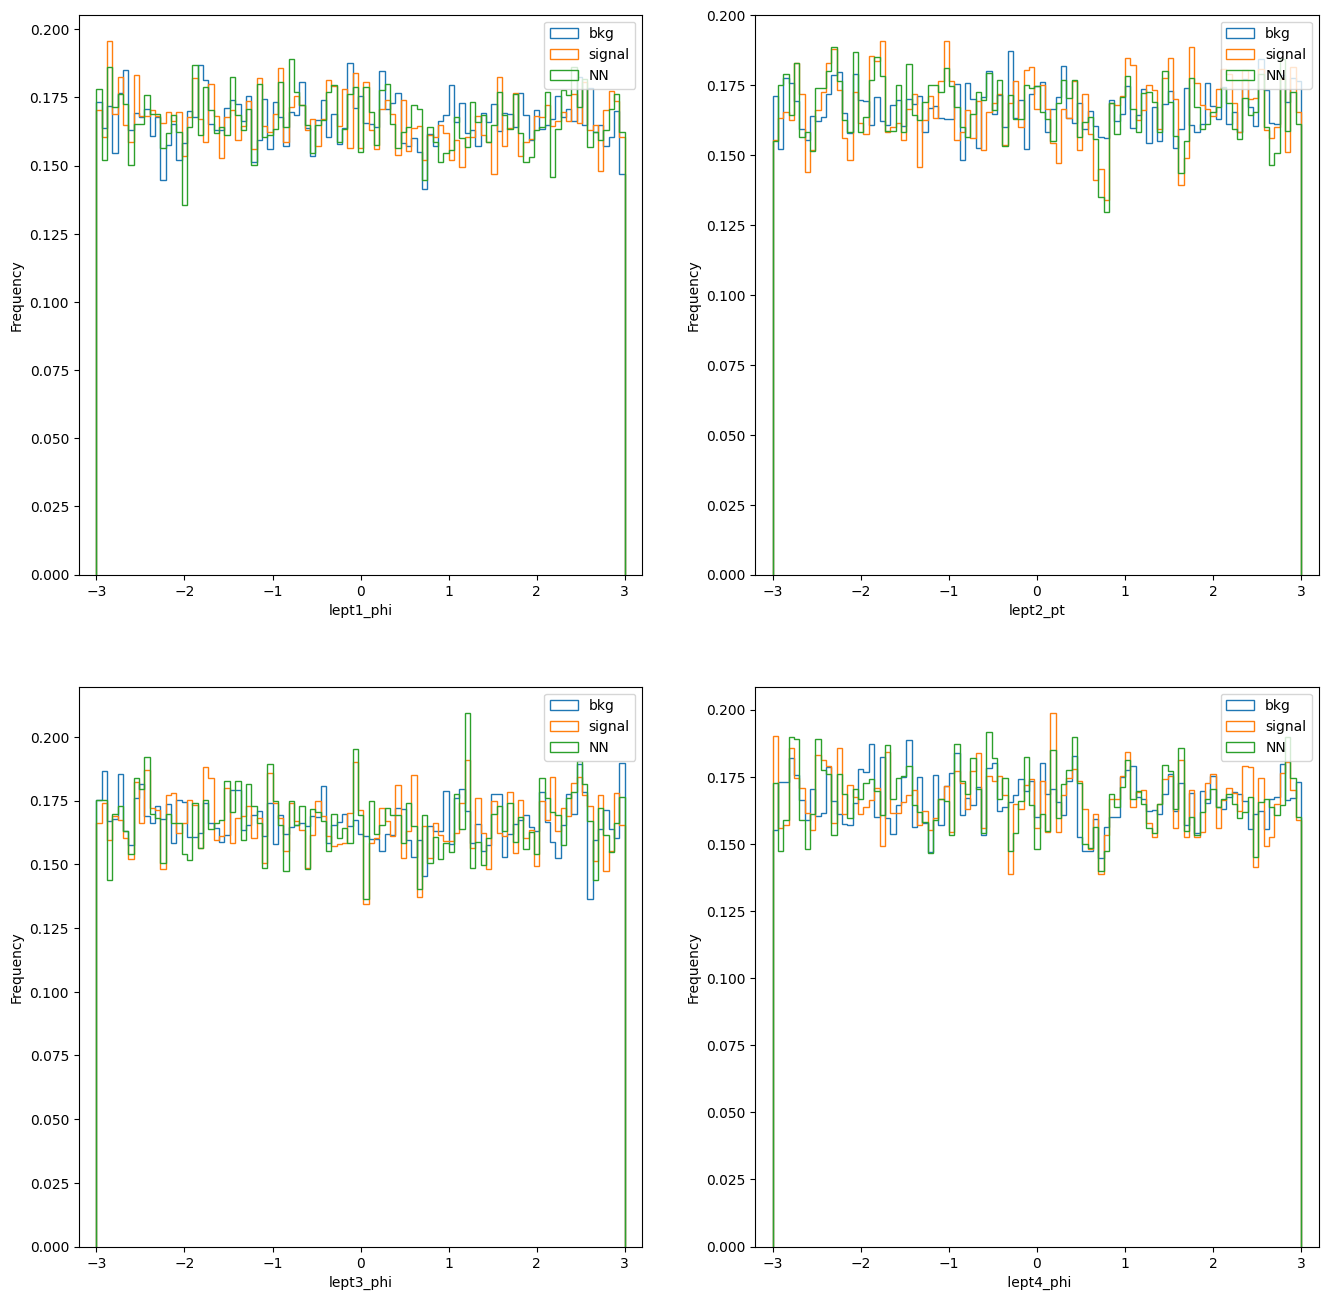

In [0]:
# Plot high level variables for signal, background and NN selected events 
plt.style.use('default') # It's ugly otherwise
plt.figure(figsize=(16, 16),dpi=100)

plt.subplot(2, 2, 1)
plt.xlabel('lept1_phi')
X = np.linspace(-3.,3.,100)
df_all['f_lept1_phi'][(df_all['isSignal'] == 0)].plot.hist(bins=X, label='bkg',histtype='step', density=1)
df_all['f_lept1_phi'][(df_all['isSignal'] == 1)].plot.hist(bins=X, label='signal',histtype='step', density=1)
df_sel['f_lept1_phi'].plot.hist(bins=X, label='NN',histtype='step', density=1)
plt.legend(loc='upper right')
plt.xlim(-3.2,3.2)

# Plot  dijets mass for signal, background and NN selected events 
plt.subplot(2, 2, 2)
plt.xlabel('lept2_pt')
X = np.linspace(-3.,3.,100)
df_all['f_lept2_phi'][(df_all['isSignal'] == 0)].plot.hist(bins=X, label='bkg',histtype='step', density=1)
df_all['f_lept2_phi'][(df_all['isSignal'] == 1)].plot.hist(bins=X, label='signal',histtype='step', density=1)
df_sel['f_lept2_phi'].plot.hist(bins=X, label='NN',histtype='step', density=1)
plt.legend(loc='upper right')
plt.xlim(-3.2,3.2)


# Plot Jet1 eta for signal, background and NN selected events 
plt.subplot(2, 2, 3)
plt.xlabel('lept3_phi')
X = np.linspace(-3.,3.,100)
df_all['f_lept3_phi'][(df_all['isSignal'] == 0)].plot.hist(bins=X, label='bkg',histtype='step', density=1)
df_all['f_lept3_phi'][(df_all['isSignal'] == 1)].plot.hist(bins=X, label='signal',histtype='step', density=1)
df_sel['f_lept3_phi'].plot.hist(bins=X, label='NN',histtype='step', density=1)
plt.legend(loc='upper right')
plt.xlim(-3.2,3.2)

# Plot Jet2 eta for signal, background and NN selected events 
plt.subplot(2, 2, 4)
plt.xlabel(' lept4_phi')
X = np.linspace(-3.,3., 100)
df_all['f_lept4_phi'][(df_all['isSignal'] == 0)].plot.hist(bins=X, label='bkg',histtype='step', density=1)
df_all['f_lept4_phi'][(df_all['isSignal'] == 1)].plot.hist(bins=X, label='signal',histtype='step', density=1)
df_sel['f_lept4_phi'].plot.hist(bins=X, label='NN',histtype='step', density=1)
plt.legend(loc='upper right')
plt.xlim(-3.2,3.2)

#pdgid to leptons 1, 2, 3 and 4

(-18.0, 18.0)

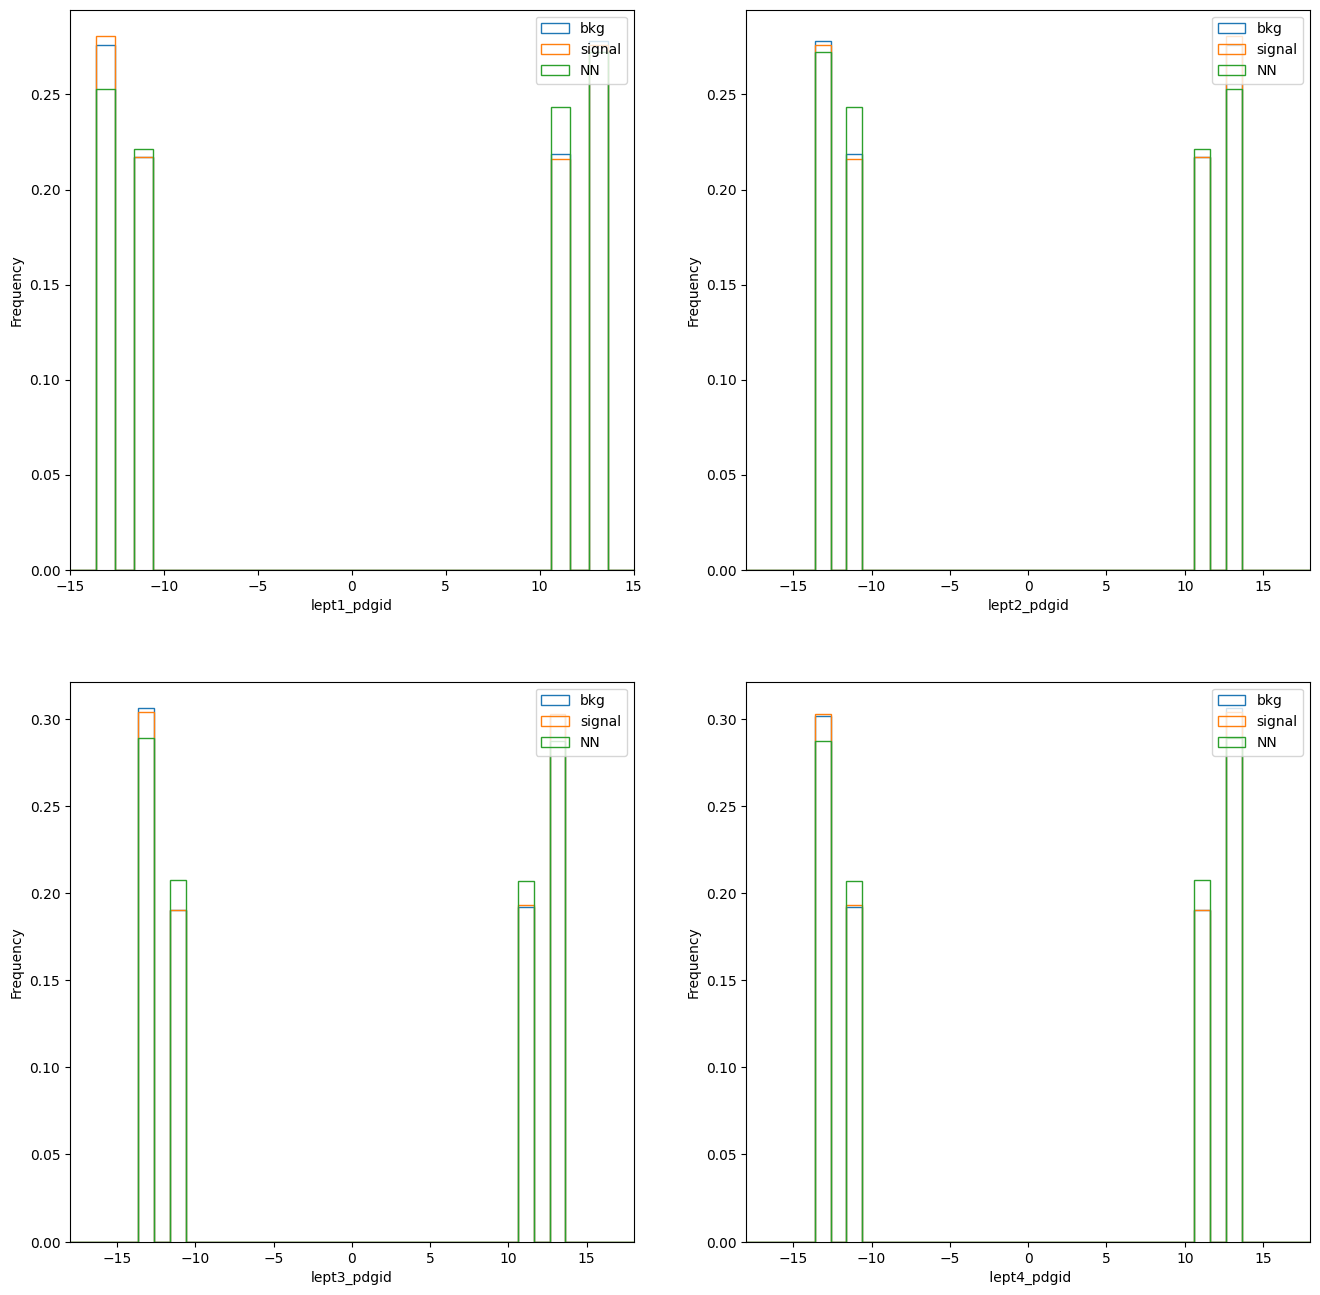

In [0]:
# Plot high level variables for signal, background and NN selected events 
plt.style.use('default') # It's ugly otherwise
plt.figure(figsize=(16, 16),dpi=100)

plt.subplot(2, 2, 1)
plt.xlabel('lept1_pdgid')
X = np.linspace(-50.,50.,100)
df_all['f_lept1_pdgid'][(df_all['isSignal'] == 0)].plot.hist(bins=X, label='bkg',histtype='step', density=1)
df_all['f_lept1_pdgid'][(df_all['isSignal'] == 1)].plot.hist(bins=X, label='signal',histtype='step', density=1)
df_sel['f_lept1_pdgid'].plot.hist(bins=X, label='NN',histtype='step', density=1)
plt.legend(loc='upper right')
plt.xlim(-15,15)

# Plot  dijets mass for signal, background and NN selected events 
plt.subplot(2, 2, 2)
plt.xlabel('lept2_pdgid')
X = np.linspace(-50.,50.,100)
df_all['f_lept2_pdgid'][(df_all['isSignal'] == 0)].plot.hist(bins=X, label='bkg',histtype='step', density=1)
df_all['f_lept2_pdgid'][(df_all['isSignal'] == 1)].plot.hist(bins=X, label='signal',histtype='step', density=1)
df_sel['f_lept2_pdgid'].plot.hist(bins=X, label='NN',histtype='step', density=1)
plt.legend(loc='upper right')
plt.xlim(-18,18)


# Plot Jet1 eta for signal, background and NN selected events 
plt.subplot(2, 2, 3)
plt.xlabel('lept3_pdgid')
X = np.linspace(-50.,50.,100)
df_all['f_lept3_pdgid'][(df_all['isSignal'] == 0)].plot.hist(bins=X, label='bkg',histtype='step', density=1)
df_all['f_lept3_pdgid'][(df_all['isSignal'] == 1)].plot.hist(bins=X, label='signal',histtype='step', density=1)
df_sel['f_lept3_pdgid'].plot.hist(bins=X, label='NN',histtype='step', density=1)
plt.legend(loc='upper right')
plt.xlim(-18,18)

# Plot Jet2 eta for signal, background and NN selected events 
plt.subplot(2, 2, 4)
plt.xlabel(' lept4_pdgid')
X = np.linspace(-50.,50.,100)
df_all['f_lept4_pdgid'][(df_all['isSignal'] == 0)].plot.hist(bins=X, label='bkg',histtype='step', density=1)
df_all['f_lept4_pdgid'][(df_all['isSignal'] == 1)].plot.hist(bins=X, label='signal',histtype='step', density=1)
df_sel['f_lept4_pdgid'].plot.hist(bins=X, label='NN',histtype='step', density=1)
plt.legend(loc='upper right')
plt.xlim(-18,18)

# Mass to Z1, Z2 and Higgs

(0.0, 120.0)

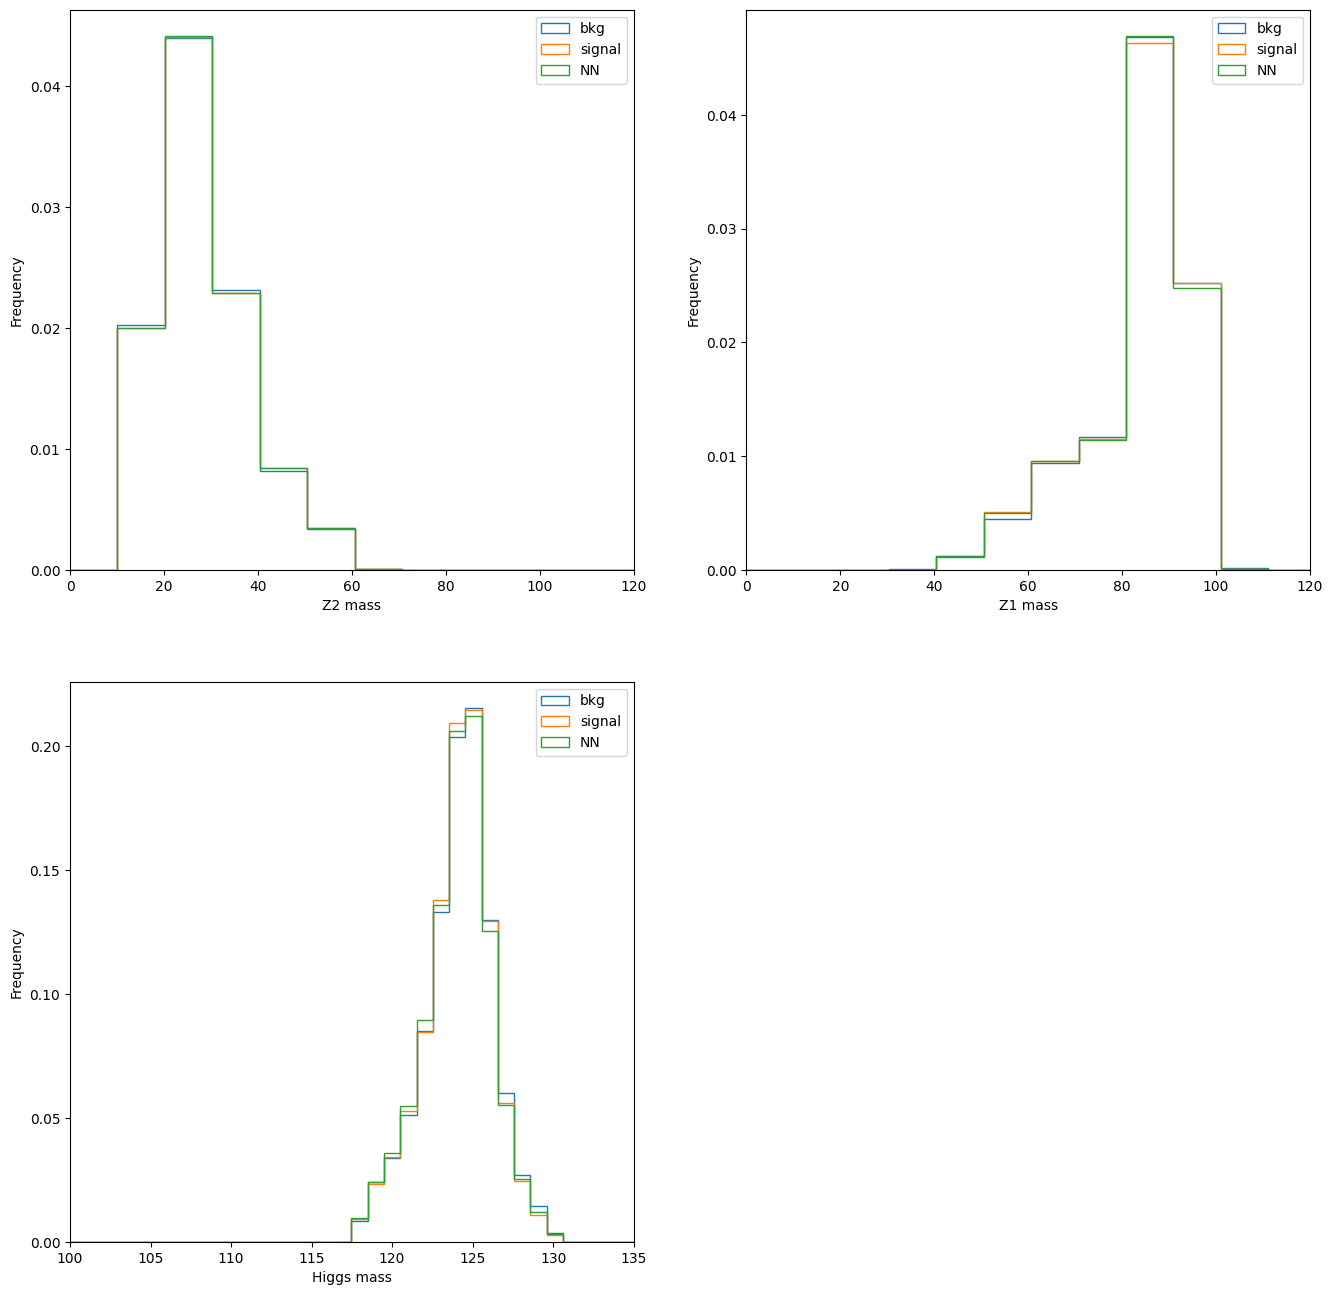

In [0]:
# Plot high level variables for signal, background and NN selected events 
plt.style.use('default') # It's ugly otherwise
plt.figure(figsize=(16, 16),dpi=100)

plt.subplot(2, 2, 3)
plt.xlabel('Higgs mass')
X = np.linspace(70,170.,100)
df_all['f_mass4l'][(df_all['isSignal'] == 0)].plot.hist(bins=X, label='bkg',histtype='step', density=1)
df_all['f_mass4l'][(df_all['isSignal'] == 1)].plot.hist(bins=X, label='signal',histtype='step', density=1)
df_sel['f_mass4l'].plot.hist(bins=X, label='NN',histtype='step', density=1)
plt.legend(loc='upper right')
plt.xlim(100.,135.)

# Plot  dijets mass for signal, background and NN selected events 
plt.subplot(2, 2, 2)
plt.xlabel('Z1 mass')
X = np.linspace(0.0,1000.,100)
df_all['f_Z1mass'][(df_all['isSignal'] == 0)].plot.hist(bins=X, label='bkg',histtype='step', density=1)
df_all['f_Z1mass'][(df_all['isSignal'] == 1)].plot.hist(bins=X, label='signal',histtype='step', density=1)
df_sel['f_Z1mass'].plot.hist(bins=X, label='NN',histtype='step', density=1)
plt.legend(loc='upper right')
plt.xlim(0,120)


# Plot Jet1 eta for signal, background and NN selected events 
plt.subplot(2, 2, 1)
plt.xlabel('Z2 mass')
X = np.linspace(0.,1000.,100)
df_all['f_Z2mass'][(df_all['isSignal'] == 0)].plot.hist(bins=X, label='bkg',histtype='step', density=1)
df_all['f_Z2mass'][(df_all['isSignal'] == 1)].plot.hist(bins=X, label='signal',histtype='step', density=1)
df_sel['f_Z2mass'].plot.hist(bins=X, label='NN',histtype='step', density=1)
plt.legend(loc='upper right')
plt.xlim(0,120)

In [0]:
descriminate = model.predict(X_test)




descriminate=(descriminate > 0.5)

print('This is a signal event?', descriminate)
print(len(descriminate))
print(len(descriminate))

This is a signal event? [[ True]
 [ True]
 [False]
 ...
 [False]
 [False]
 [ True]]
14190
14190


#Matrix confusion

In [0]:
from sklearn.metrics import confusion_matrix, accuracy_score
precision = accuracy_score(Y_test, descriminate)
print('precisão=', precision)
matrix = confusion_matrix(Y_test, descriminate)
print('Confusion Matrix=')
print(matrix)

precisão= 0.7473572938689218
Confusion Matrix=
[[6869 1997]
 [1588 3736]]


#Classification Report

In [0]:
from sklearn.metrics import precision_score, classification_report

cut = 0.5
predictions = np.where(descriminate, 1., 0.)
print(predictions)
print('y=',  Y_test)
precision=precision_score(Y_test, predictions,  labels=None, pos_label=1, average=None, sample_weight=None)
print('precison=', precision) #with avarage = None, We have  precision= ( binary 1 and 0)

report = classification_report(Y_test, predictions)
print(report)

[[1.]
 [1.]
 [0.]
 ...
 [0.]
 [0.]
 [1.]]
y= [[0.]
 [0.]
 [0.]
 ...
 [1.]
 [0.]
 [0.]]
precison= [0.81222656 0.65166579]
              precision    recall  f1-score   support

         0.0       0.81      0.77      0.79      8866
         1.0       0.65      0.70      0.68      5324

    accuracy                           0.75     14190
   macro avg       0.73      0.74      0.73     14190
weighted avg       0.75      0.75      0.75     14190

